# 1. Data preprocessing

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import re
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# Data sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Define Domains
df1['domain'], df2['domain'] = 1, 2

# Split set 1
x1_tr, x_dv = train_test_split(df1, stratify=df1['label'], random_state=0, test_size=0.2)
# Split set 2
x2_1 = df2[df2['label'] == 1].sample(500, random_state=0)
x2_0 = df2[df2['label'] == 0].sample(500, random_state=0)
x2_tr = df2[[i not in list(pd.concat([x2_1, x2_0]).reset_index()['index']) for i in df2.index]].reset_index(drop=True)
x2_dev = pd.concat([x2_1,x2_0]).reset_index(drop=True)

# Train test sets
x_train = pd.concat([x1_tr, x2_tr]).sample(frac=1).reset_index(drop=True)
x_dev_ = pd.concat([x_dv, x2_dev]).sample(frac=1).reset_index(drop=True)

# Transform numbers to strings to treat them as tokens
txt1 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x1_tr['text']]
txt2 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x2_tr['text']]
aug_txt = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in x_train['text']]

# Final train test sets
x_tr_aug, y_train = aug_txt, x_train['label']
x_dev_, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x_dev_['text']], np.array(x_dev_['label'].astype('float32'))

# Print classes proportion
print(round(y_train.value_counts()/len(y_train),2))

label
0    0.81
1    0.19
Name: count, dtype: float64


# 2. Encoding

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Tokens encoding to sparce matrix (Countv)
Cvec = CountVectorizer(ngram_range=(8,9))
x_train_c = Cvec.fit_transform(x_tr_aug)
x_dev_c = Cvec.transform(x_dev_)


# Tokens encoding to sparce matrix (Tfid)
Tvec = TfidfVectorizer()
x_train_t = Tvec.fit_transform(x_tr_aug)
x_dev_t = Tvec.transform(x_dev_)

In [5]:
x_dev_c.shape

(2000, 5154787)

### Logistic model

In [20]:
from sklearn.linear_model import LogisticRegression

# Train models
cl_aug_c = LogisticRegression().fit(x_train_c, y_train)
cl_aug_t = LogisticRegression().fit(x_train_t, y_train)
cl_aug_c_w = LogisticRegression(class_weight="balanced").fit(x_train_c, y_train)
cl_aug_t_w = LogisticRegression(class_weight="balanced").fit(x_train_t, y_train)

In [21]:
# Data augmentation scores
sc_aug_c_tr, sc_aug_c_ts = cl_aug_c.score(x_train_c, y_train), cl_aug_c.score(x_dev_c, y_dev)
sc_aug_t_tr, sc_aug_t_ts = cl_aug_t.score(x_train_t, y_train), cl_aug_t.score(x_dev_t, y_dev)
sc_aug_c_w_tr, sc_aug_c_w_ts = cl_aug_c_w.score(x_train_c, y_train), cl_aug_c_w.score(x_dev_c, y_dev)
sc_aug_t_w_tr, sc_aug_t_w_ts = cl_aug_t_w.score(x_train_t, y_train), cl_aug_t_w.score(x_dev_t, y_dev)
# F1 scores
f1_aug_c_tr, f1_aug_c_ts = f1_score(y_train, cl_aug_c.predict(x_train_c)), f1_score(y_dev, cl_aug_c.predict(x_dev_c))
f1_aug_t_tr, f1_aug_t_ts = f1_score(y_train, cl_aug_t.predict(x_train_t)), f1_score(y_dev, cl_aug_t.predict(x_dev_t))
f1_aug_c_w_tr, f1_aug_c_w_ts = f1_score(y_train, cl_aug_c_w.predict(x_train_c)), f1_score(y_dev, cl_aug_c_w.predict(x_dev_c))
f1_aug_t_w_tr, f1_aug_t_w_ts = f1_score(y_train, cl_aug_t_w.predict(x_train_t)), f1_score(y_dev, cl_aug_t_w.predict(x_dev_t))

# Print scores
print(f'Model -DA using  Cvec:\t\ttr_acc: {sc_aug_c_tr:.3f}\tval_acc: {sc_aug_c_ts:.3f}\ttr_F1" {f1_aug_c_tr:.3f}\tts_F1" {f1_aug_c_ts:.3f}')
print(f'Model -DA using  Cvec-w:\ttr_acc: {sc_aug_c_w_tr:.3f}\tval_acc: {sc_aug_c_w_ts:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_c_w_ts:.3f}')
print()
print(f'Model -DA using  Tvec:\t\ttr_acc: {sc_aug_t_tr:.3f}\tval_acc: {f1_aug_t_tr:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_t_ts:.3f}')
print(f'Model -DA using  Tvec-w:\ttr_acc: {sc_aug_t_w_tr:.3f}\tval_acc: {sc_aug_t_w_ts:.3f}\ttr_F1" {f1_aug_t_w_tr:.3f}\tts_F1" {f1_aug_t_w_ts:.3f}')

Model -DA using  Cvec:		tr_acc: 0.999	val_acc: 0.495	tr_F1" 0.997	ts_F1" 0.000
Model -DA using  Cvec-w:	tr_acc: 1.000	val_acc: 0.933	tr_F1" 1.000	ts_F1" 0.933

Model -DA using  Tvec:		tr_acc: 0.892	val_acc: 0.639	tr_F1" 1.000	ts_F1" 0.420
Model -DA using  Tvec-w:	tr_acc: 0.895	val_acc: 0.597	tr_F1" 0.772	ts_F1" 0.602


In [ ]:
# Data augmentation scores
sc_aug_c_tr, sc_aug_c_ts = cl_aug_c.score(x_train_c, y_train), cl_aug_c.score(x_dev_c, y_dev)
sc_aug_t_tr, sc_aug_t_ts = cl_aug_t.score(x_train_t, y_train), cl_aug_t.score(x_dev_t, y_dev)
sc_aug_c_w_tr, sc_aug_c_w_ts = cl_aug_c_w.score(x_train_c, y_train), cl_aug_c_w.score(x_dev_c, y_dev)
sc_aug_t_w_tr, sc_aug_t_w_ts = cl_aug_t_w.score(x_train_t, y_train), cl_aug_t_w.score(x_dev_t, y_dev)
# F1 scores
f1_aug_c_tr, f1_aug_c_ts = f1_score(y_train, cl_aug_c.predict(x_train_c)), f1_score(y_dev, cl_aug_c.predict(x_dev_c))
f1_aug_t_tr, f1_aug_t_ts = f1_score(y_train, cl_aug_t.predict(x_train_t)), f1_score(y_dev, cl_aug_t.predict(x_dev_t))
f1_aug_c_w_tr, f1_aug_c_w_ts = f1_score(y_train, cl_aug_c_w.predict(x_train_c)), f1_score(y_dev, cl_aug_c_w.predict(x_dev_c))
f1_aug_t_w_tr, f1_aug_t_w_ts = f1_score(y_train, cl_aug_t_w.predict(x_train_t)), f1_score(y_dev, cl_aug_t_w.predict(x_dev_t))

# Print scores
print(f'Model -DA using  Cvec:\t\ttr_acc: {sc_aug_c_tr:.3f}\tval_acc: {sc_aug_c_ts:.3f}\ttr_F1" {f1_aug_c_tr:.3f}\tts_F1" {f1_aug_c_ts:.3f}')
print(f'Model -DA using  Cvec-w:\ttr_acc: {sc_aug_c_w_tr:.3f}\tval_acc: {sc_aug_c_w_ts:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_c_w_ts:.3f}')
print()
print(f'Model -DA using  Tvec:\t\ttr_acc: {sc_aug_t_tr:.3f}\tval_acc: {f1_aug_t_tr:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_t_ts:.3f}')
print(f'Model -DA using  Tvec-w:\ttr_acc: {sc_aug_t_w_tr:.3f}\tval_acc: {sc_aug_t_w_ts:.3f}\ttr_F1" {f1_aug_t_w_tr:.3f}\tts_F1" {f1_aug_t_w_ts:.3f}')

Model -DA using  Cvec:		tr_acc: 0.998	val_acc: 0.495	tr_F1" 0.995	ts_F1" 0.000
Model -DA using  Cvec-w:	tr_acc: 1.000	val_acc: 0.931	tr_F1" 1.000	ts_F1" 0.931

Model -DA using  Tvec:		tr_acc: 0.892	val_acc: 0.639	tr_F1" 1.000	ts_F1" 0.420
Model -DA using  Tvec-w:	tr_acc: 0.895	val_acc: 0.597	tr_F1" 0.772	ts_F1" 0.602


In [22]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in test]
test_c = Cvec.transform(test)

preds = cl_aug_c_w.predict(test_c)

test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('../Data/predictions.csv', index=False)

In [23]:
df_full = pd.concat([df1, df2]).sample(frac=1).reset_index(drop=True)
txt_full = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_full['text']]
# Full vect
Cvec_f = CountVectorizer(ngram_range=(8,9))
x_full = Cvec_f.fit_transform(txt_full)
y_full = df_full['label']
# Full model
cl_aug_c_w = LogisticRegression(class_weight="balanced").fit(x_full, y_full)

In [24]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in test]
test_c = Cvec_f.transform(test)

preds = cl_aug_c_w.predict(test_c)

test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('../Data/predictions.csv', index=False)

In [14]:
# Helper function to get model metrics
def max_pr(pr, y):
    l = []
    p, r = [], []
    min = 1
    y_ = pd.Series(y)
    for i in range(1,100):
        # ACC
        acc = sum([0 if p < i/100 else 1 for p in pr[1]] == y)/len(y)
        l.append(acc)
        # Precision
        ind_0 = y_[y_==0].index
        prec = sum([0 if p < i/100 else 1 for p in pr[1][ind_0]] == y_[y_==0])/len(ind_0)
        p.append(prec)
        # Recall
        ind_1 = y_[y_==1].index
        rec = sum([0 if p < i/100 else 1 for p in pr[1][ind_1]] == y_[y_==1])/len(ind_1)
        r.append(rec)
        # Closest point
        if abs((acc-prec)+(acc-rec)+(rec-prec)/3) < min:
            min = abs((acc-prec)+(acc-rec)+(rec-prec)/3)
            ind = i

    print(f'Acc: {l[ind-1]:.3f}, Precision: {p[ind-1]:.3f}, Recall: {r[ind-1]:.3f}, Closest point: {ind-1:.3f}')
    return l, p, r, ind-1

# Helper function to plot model probabilities
def plot_ptobs(p_tr, p_dv, acc, prec, rec):
    # Plot Training probabilities
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle('Probabilities distribution')
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter([i for i in range(len(y_train))], p_tr[0], c=y_train)
    ax1.set_title('Training probabilities')
    ax1.set_xlabel('Observation')
    ax1.set_ylabel('Probability')
    ax1.legend(['Label 1','Label 0'])
    # Plot Test probabilities
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter([i for i in range(len(y_dev))], p_dv[0], c=y_dev)
    ax2.set_title('Dev probabilities')
    ax2.set_xlabel('Observation')
    ax2.set_ylabel('Probability')
    ax2.legend(['Label 1','Label 0'])
    # Plot test thresholds
    ax3 = fig.add_subplot(2, 2, 3) 
    ax3.plot(acc, ls='--')
    ax3.plot(prec)
    ax3.plot(rec)
    ax3.vlines(min, 0, 1, colors='r', ls=':')
    ax3.set_title('Threshold tradeoff')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('Probability')
    ax3.legend(['Accuracy','Precision','Recall', 'Threshold'])

    plt.show()

Acc: 0.933, Precision: 0.932, Recall: 0.935, Closest point: 28.000


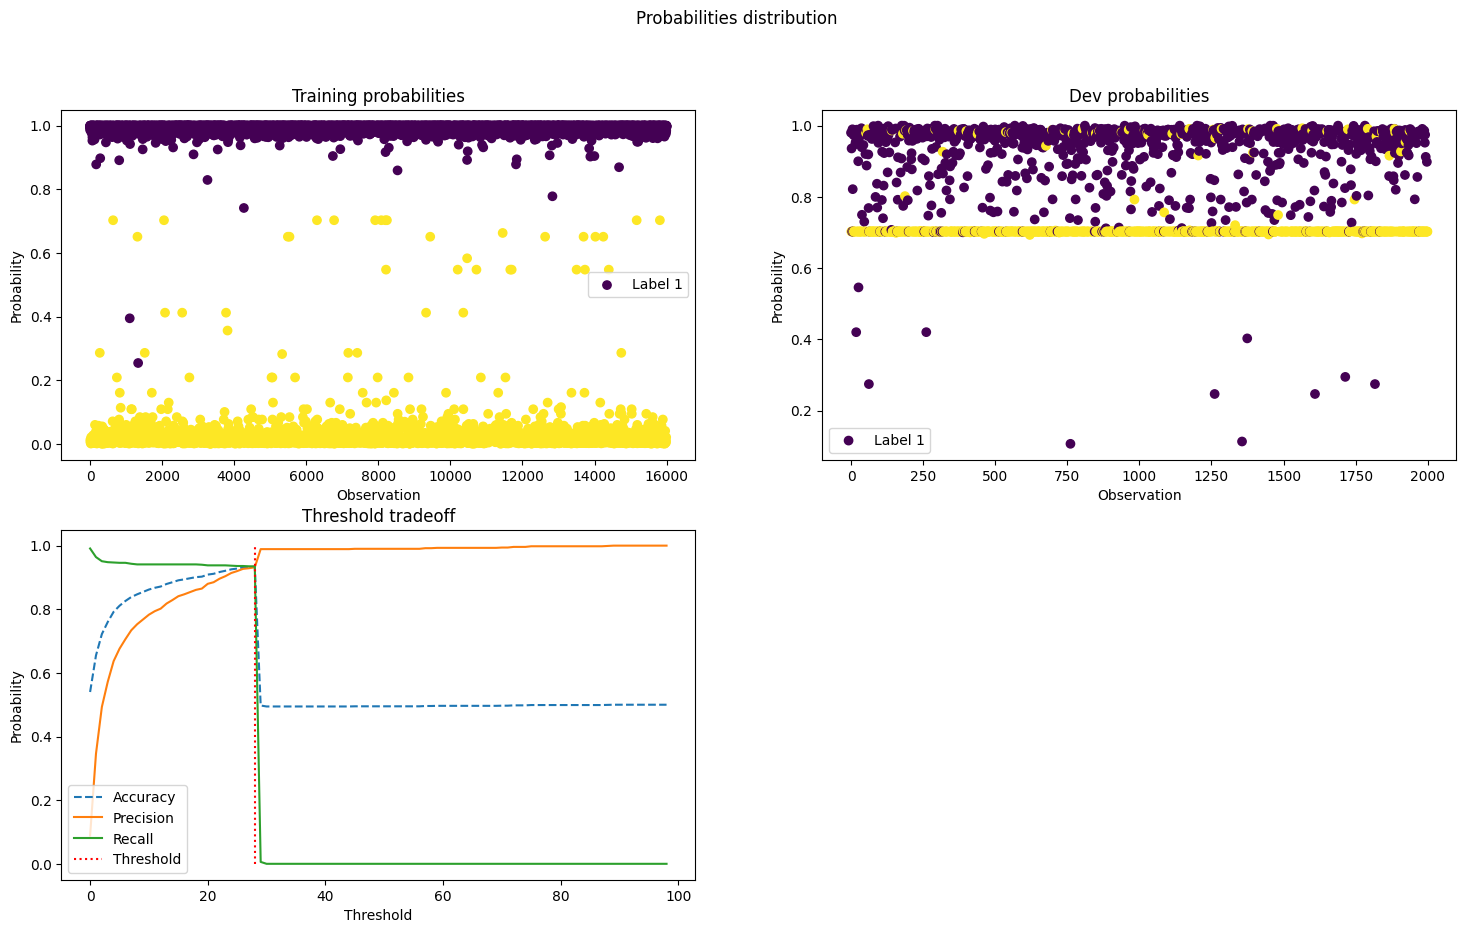

In [15]:
p_tr = cl_aug_c.predict_proba(x_train_c).T
p_dv = cl_aug_c.predict_proba(x_dev_c).T
acc, prec, rec, min = max_pr(p_dv, y_dev)
plot_ptobs(p_tr, p_dv, acc, prec, rec)

### Undersampling and oversampling LR

In [9]:
X_train_, y_train_ = RandomUnderSampler(random_state=0).fit_resample(x_train_c, y_train)
print(pd.Series(y_train_).value_counts())
cl_u = LogisticRegression(class_weight="balanced").fit(X_train_, y_train_)
print(f'Train Accuracy:{cl_u.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, cl_u.predict(X_train_)):.3f}\
        Test Accuracy: {cl_u.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, cl_u.predict(x_dev_c)):.3f}')

label
0    3000
1    3000
Name: count, dtype: int64
Train Accuracy:1.000, Train F1:1.000        Test Accuracy: 0.698, Test F1:0.761


In [10]:
X_train_, y_train_ = RandomOverSampler(random_state=0).fit_resample(x_train_c, y_train)
print(pd.Series(y_train_).value_counts())
cl_u = LogisticRegression(class_weight="balanced").fit(X_train_, y_train_)
print(f'Train Accuracy:{cl_u.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, cl_u.predict(X_train_)):.3f}\
        Test Accuracy: {cl_u.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, cl_u.predict(x_dev_c)):.3f}')

label
0    13000
1    13000
Name: count, dtype: int64
Train Accuracy:1.000, Train F1:1.000        Test Accuracy: 0.921, Test F1:0.923


Acc: 0.933, Precision: 0.935, Recall: 0.932, Closest point: 58.000


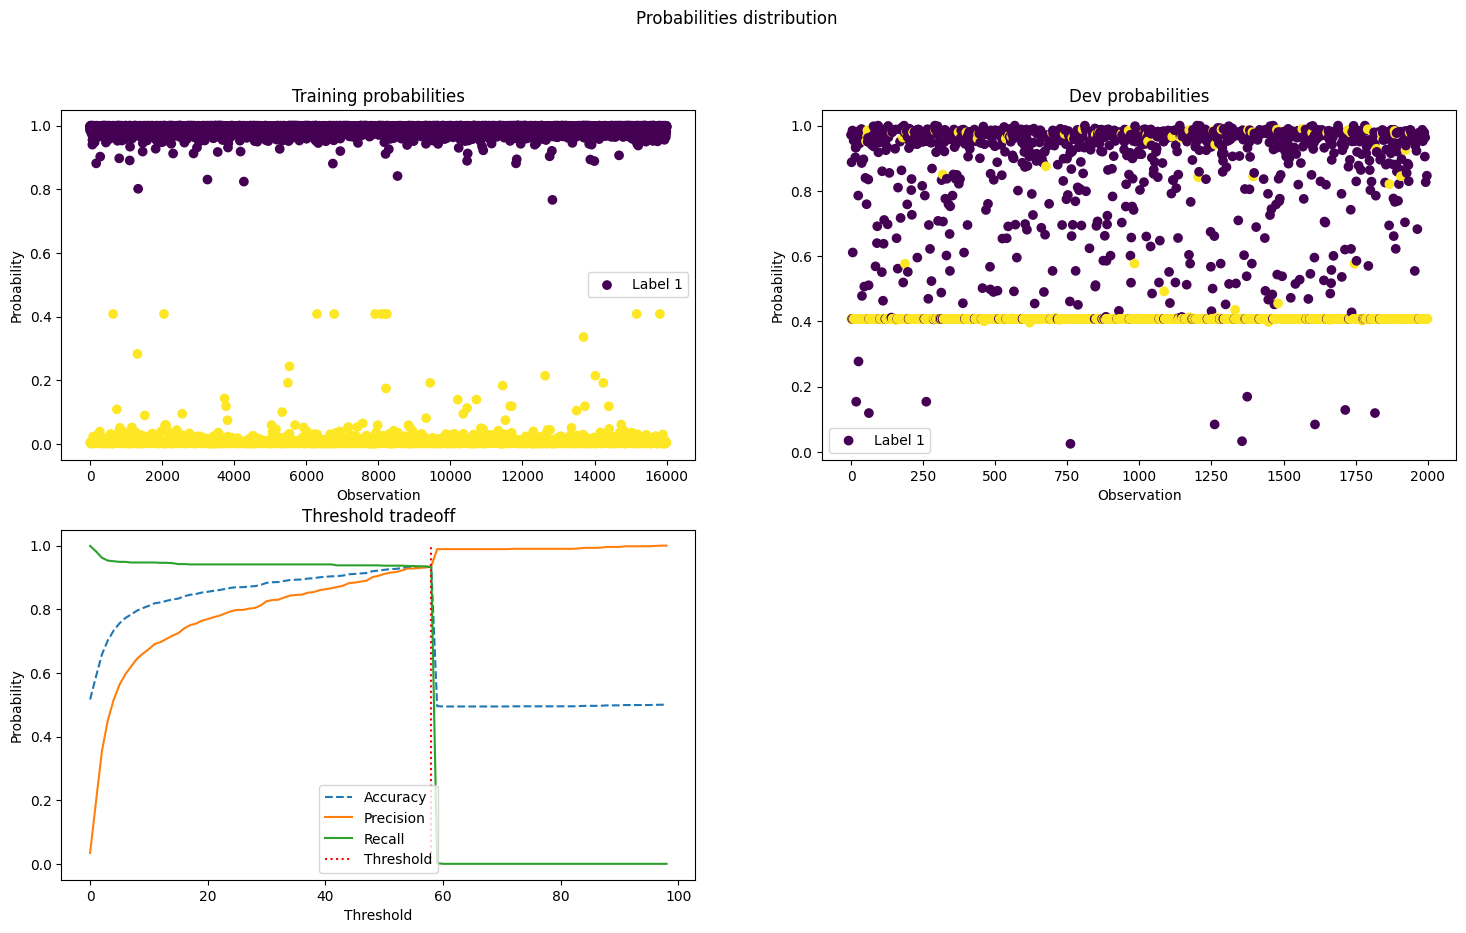

In [16]:
p_tr = cl_u.predict_proba(x_train_c).T
p_dv = cl_u.predict_proba(x_dev_c).T
acc, prec, rec, min = max_pr(p_dv, y_dev)
plot_ptobs(p_tr, p_dv, acc, prec, rec)

### Grid search

In [17]:
import warnings
warnings.filterwarnings('ignore')

# Instanciate model
lr = LogisticRegression()
# Define parameters to tune
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
# Instanciate grid search
grid_lr = GridSearchCV(estimator = lr,  
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           verbose=1)
# Start the search
grid_lr.fit(X_train_, y_train_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='roc_auc', verbose=1)

In [20]:
print(f'Train Accuracy:{grid_lr.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, grid_lr.predict(X_train_)):.3f}\
        Test Accuracy: {grid_lr.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, grid_lr.predict(x_dev_c)):.3f}')

Train Accuracy:1.000, Train F1:1.000        Test Accuracy: 0.922, Test F1:0.921


Acc: 0.933, Precision: 0.932, Recall: 0.934, Closest point: 58.000


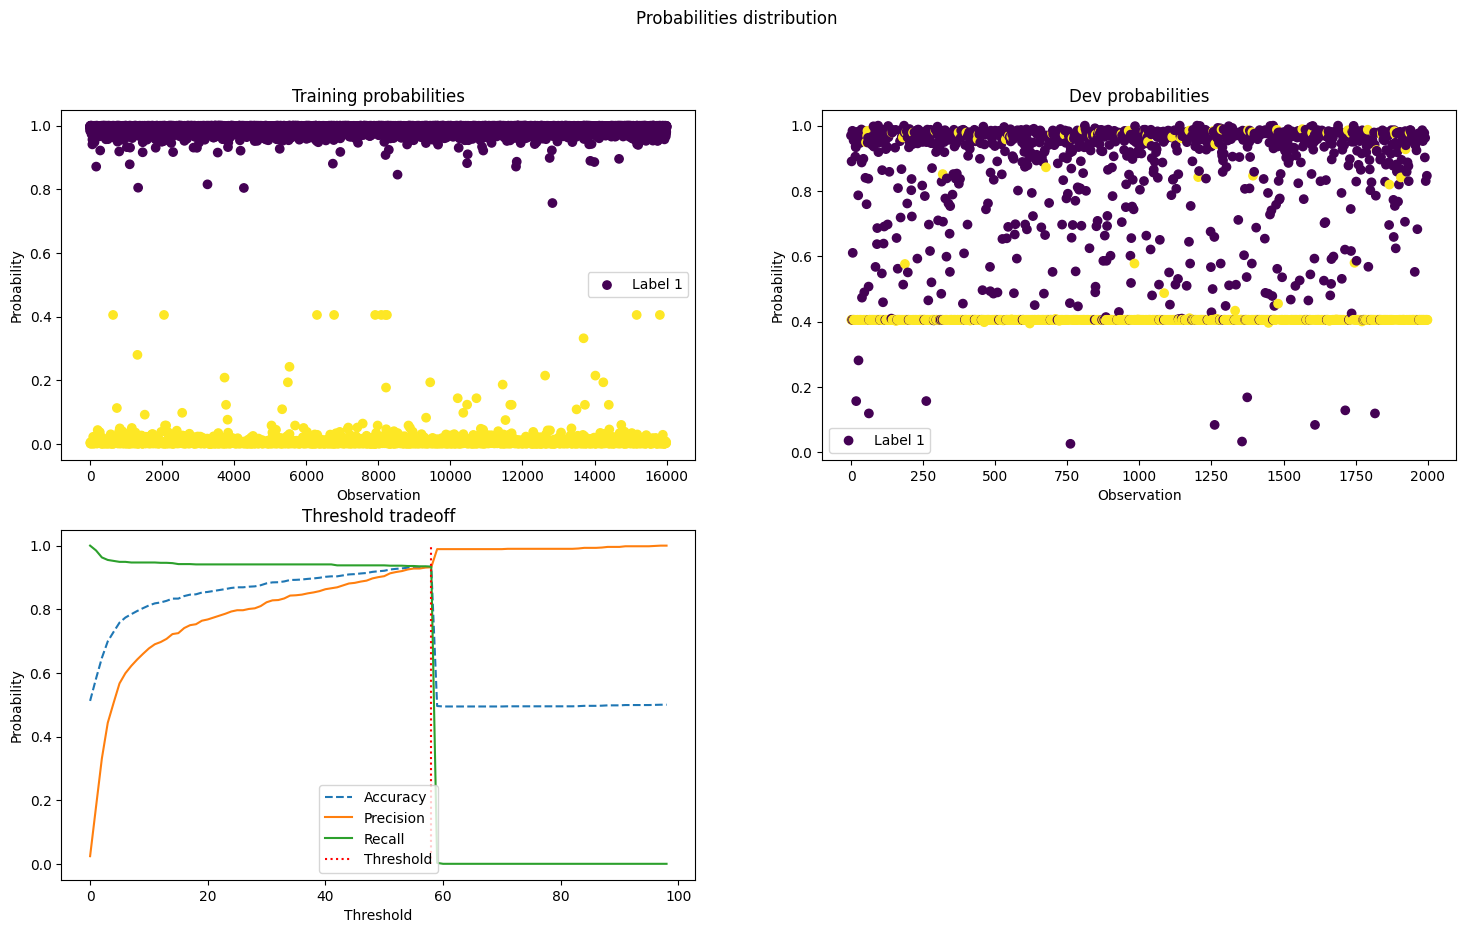

In [21]:
p_tr = grid_lr.predict_proba(x_train_c).T
p_dv = grid_lr.predict_proba(x_dev_c).T
acc, prec, rec, min = max_pr(p_dv, y_dev)
plot_ptobs(p_tr, p_dv, acc, prec, rec)

# Train LGBM

In [22]:
import lightgbm as lgb
X_train_, y_train_ = RandomUnderSampler(random_state=0).fit_resample(x_train_c, y_train)
X_train_, y_train_ = X_train_.astype('float32'), y_train_.astype('float32')
x_dev_c, y_dev = x_dev_c.astype('float32'), y_dev.astype('float32')

lgb_train_u = lgb.LGBMClassifier().fit(X_train_, y_train_)
print(f'Train Accuracy:{lgb_train_u.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, lgb_train_u.predict(X_train_)):.3f}\
        Test Accuracy: {lgb_train_u.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, lgb_train_u.predict(x_dev_c)):.3f}')

[LightGBM] [Info] Number of positive: 3000, number of negative: 3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [266]:
X_train_, y_train_ = RandomOverSampler(random_state=0).fit_resample(x_train_c, y_train)
X_train_, y_train_ = X_train_.astype('float32'), y_train_.astype('float32')

lgb_train = lgb.LGBMClassifier().fit(X_train_, y_train_)
print(f'Train Accuracy:{lgb_train.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, lgb_train.predict(X_train_)):.3f}\
        Test Accuracy: {lgb_train.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, lgb_train.predict(x_dev_c)):.3f}')

[LightGBM] [Info] Number of positive: 13000, number of negative: 13000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.392887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44780
[LightGBM] [Info] Number of data points in the train set: 26000, number of used features: 9968
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Train Accuracy:0.933, Train F1:0.935        Test Accuracy: 0.669, Test F1:0.675


In [285]:
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}

lgb_ = lgb.LGBMClassifier(metric='f1', objective='binary', random_state=42)

grid_lgbm = GridSearchCV(lgb_, params, scoring='roc_auc', cv=2, verbose=1)
grid_lgbm.fit(X_train_, y_train_)

Fitting 2 folds for each of 216 candidates, totalling 432 fits
[LightGBM] [Info] Number of positive: 1500, number of negative: 1500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11470
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 2712
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1500, number of negative: 1500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11275
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 2709
[LightGBM]

GridSearchCV(cv=2,
             estimator=LGBMClassifier(metric='f1', objective='binary',
                                      random_state=42),
             param_grid={'learning_rate': [0.1, 0.03, 0.003],
                         'max_depth': [-1, 3, 5],
                         'n_estimators': [50, 100, 200, 500],
                         'num_leaves': [7, 14, 21, 28, 31, 50]},
             scoring='roc_auc', verbose=1)

In [287]:
print(f'Train Accuracy:{grid_lgbm.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, grid_lgbm.predict(X_train_)):.3f}\
        Test Accuracy: {grid_lgbm.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, grid_lgbm.predict(x_dev_c)):.3f}')

Train Accuracy:1.000, Train F1:0.997        Test Accuracy: 0.785, Test F1:0.735


Acc: 0.692, Precision: 0.689, Recall: 0.694, Closest point: 64.000


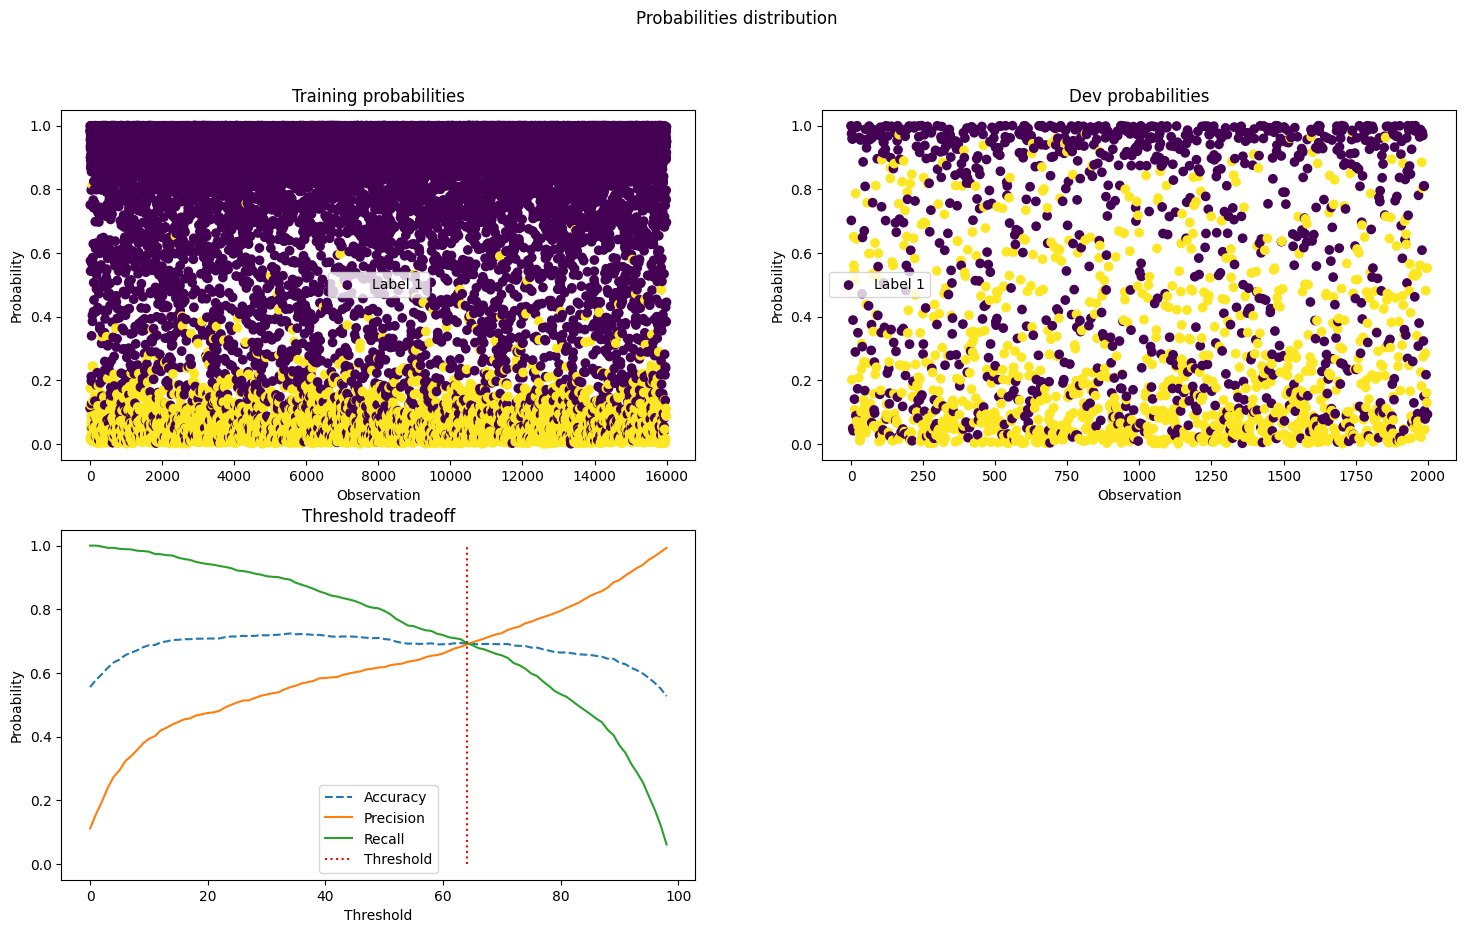

In [288]:
p_tr = grid.predict_proba(x_train_c.astype('float32')).T
p_dv = grid.predict_proba(x_dev_c.astype('float32')).T
acc, prec, rec, min = max_pr(p_dv.astype('float32'), y_dev.astype('float32'))
plot_ptobs(p_tr, p_dv, acc, prec, rec)

### SVM

In [7]:
from sklearn.svm import SVC
X_train_, y_train_ = RandomUnderSampler(random_state=0).fit_resample(x_train_t, y_train)
svm = SVC(kernel='linear').fit(X_train_, y_train_)
print(f'Train Accuracy:{svm.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, svm.predict(X_train_)):.3f}\
        Test Accuracy: {svm.score(x_dev_t, y_dev):.3f}, Test F1:{f1_score(y_dev, svm.predict(x_dev_t)):.3f}')

NameError: name 'f1_score' is not defined

In [ ]:
X_train_, y_train_ = RandomOverSampler(random_state=0).fit_resample(x_train_t, y_train)
print(pd.Series(y_train_).value_counts())
svm = LogisticRegression().fit(X_train_, y_train_)
print(f'Train Accuracy:{svm.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, svm.predict(X_train_)):.3f}\
        Test Accuracy: {svm.score(x_dev_t, y_dev):.3f}, Test F1:{f1_score(y_dev, svm.predict(x_dev_t)):.3f}')

In [319]:


svm = SVC(kernel='linear').fit(X_train_, y_train_)
print(f'Train Accuracy:{svm.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, svm.predict(X_train_)):.3f}\
        Test Accuracy: {svm.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, svm.predict(x_dev_c)):.3f}')

Train Accuracy:1.000, Train F1:1.000        Test Accuracy: 0.647, Test F1:0.657


In [311]:
sum(svm.predict(x_dev_c) == y_dev)/len(y_dev)

0.634

In [315]:
params = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

svm_ = SVC(random_state=42)

grid_svm = GridSearchCV(svm_, params, scoring='roc_auc', cv=3, verbose=3)
grid_svm.fit(X_train_, y_train_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


KeyboardInterrupt: 

In [ ]:
print(f'Train Accuracy:{grid_svm.score(X_train_, y_train_):.3f}, Train F1:{f1_score(y_train_, grid_svm.predict(X_train_)):.3f}\
        Test Accuracy: {grid_svm.score(x_dev_c, y_dev):.3f}, Test F1:{f1_score(y_dev, grid_svm.predict(x_dev_c)):.3f}')

Train Accuracy:0.879, Train F1:0.878        Test Accuracy: 0.634, Test F1:0.646


### Ensemble model prediction (MV)

In [ ]:
lr_pred = grid_lr
lgbm_pred = grid_lgbm
svm_pred = grid_svm

In [23]:
from sklearn.decomposition import PCA

In [82]:
pca = PCA(n_components=2, svd_solver='arpack')
comps = pca.fit_transform(x_train_c)

dev_comp = pca.transform(x_dev_c)

In [83]:
cl_pca = LogisticRegression(class_weight="balanced").fit(comps, y_train)
print(f'Train Accuracy:{cl_pca.score(comps, y_train):.3f}, Train F1:{f1_score(y_train, cl_pca.predict(comps)):.3f}\
        Test Accuracy: {cl_pca.score(dev_comp, y_dev):.3f}, Test F1:{f1_score(y_dev, cl_pca.predict(dev_comp)):.3f}')

Train Accuracy:0.190, Train F1:0.316        Test Accuracy: 0.504, Test F1:0.668


In [85]:
from sklearn.svm import SVC
svm = SVC().fit(comps, y_train)
print(f'Train Accuracy:{svm.score(comps, y_train):.3f}, Train F1:{f1_score(y_train, svm.predict(comps)):.3f}\
        Test Accuracy: {svm.score(dev_comp, y_dev):.3f}, Test F1:{f1_score(y_dev, svm.predict(dev_comp)):.3f}')

Train Accuracy:0.812, Train F1:0.000        Test Accuracy: 0.500, Test F1:0.000
